In [11]:
!pip install seaborn



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [118]:
import os
import shutil

# move the data and change the file name to the new pattern
pattern = "locustfile_even_high_0.2_400_40_120s"
directory = './pet/coarse/'
new_folder = "./pet/latency_data"

os.makedirs(new_folder, exist_ok=True)

counter = 1
#print(os.listdir(directory))
for filename in os.listdir(directory):
    if filename.startswith(pattern) and filename.endswith(".csv"):
        new_filename = f"coarse_even_high_{counter}.csv"
        shutil.move(os.path.join(directory, filename), os.path.join(new_folder, new_filename))
        counter += 1

print("Files have been moved and renamed successfully.")


Files have been moved and renamed successfully.


In [119]:
#extract metadata from the file name and add it as columns to the dataframe
import pandas as pd
import glob
import os

def extract_metadata(filename):
    parts = filename.split('_')
    granularity = parts[0]
    request_amount = parts[1]
    distribution = parts[2]
    iteration = parts[3].split('.')[0]
    return granularity, request_amount, distribution, iteration

csv_files_train = glob.glob('./train/latency_data/*.csv')
csv_files_pet = glob.glob('./pet/latency_data/*.csv')
all_data_train = []
all_data_pet = []

for file in csv_files_pet:
    filename = os.path.basename(file)
    granularity, request_amount, distribution, iteration = extract_metadata(filename)

    df = pd.read_csv(file)
    df['Granularity'] = granularity
    df['Request_Amount'] = request_amount
    df['Distribution'] = distribution
    df['Iteration'] = iteration

    all_data_pet.append(df)

for file in csv_files_train:
    filename = os.path.basename(file)
    granularity, request_amount, distribution, iteration = extract_metadata(filename)

    df = pd.read_csv(file)
    df['Granularity'] = granularity
    df['Request_Amount'] = request_amount
    df['Distribution'] = distribution
    df['Iteration'] = iteration

    all_data_train.append(df)

combined_df_train = pd.concat(all_data_train, ignore_index=True)
combined_df_pet = pd.concat(all_data_pet, ignore_index=True)

In [120]:
combined_df_train['Timestamp'] = pd.to_datetime(combined_df_train['Timestamp'])
combined_df_train['Response Time (ms)'] = pd.to_numeric(combined_df_pet['Response Time (ms)'], errors='coerce')
combined_df_pet['Timestamp'] = pd.to_datetime(combined_df_pet['Timestamp'])
combined_df_pet['Response Time (ms)'] = pd.to_numeric(combined_df_pet['Response Time (ms)'], errors='coerce')
combined_df_pet = combined_df_pet.dropna()
combined_df_train = combined_df_train.dropna()
# Create an identifier for each experimental run
combined_df_pet['Experiment_ID'] = combined_df_pet['Granularity'] + '_' + combined_df_pet['Request_Amount'] + '_' + combined_df_pet['Distribution'] + '_' + combined_df_pet['Iteration']
combined_df_train['Experiment_ID'] = combined_df_train['Granularity'] + '_' + combined_df_train['Request_Amount'] + '_' + combined_df_train['Distribution'] + '_' + combined_df_train['Iteration']

/var/folders/n3/t4x6rcxd63361_hz54mh10qh0000gn/T/ipykernel_69873/3154925520.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_train['Timestamp'] = pd.to_datetime(combined_df_train['Timestamp'])
/var/folders/n3/t4x6rcxd63361_hz54mh10qh0000gn/T/ipykernel_69873/3154925520.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df_pet['Timestamp'] = pd.to_datetime(combined_df_pet['Timestamp'])


In [131]:
# Calculate average latency for each experimental run
latency_summary_pet = combined_df_pet.groupby('Experiment_ID').agg({
    'Response Time (ms)': 'mean',
    'Granularity': 'first',
    'Request_Amount': 'first',
    'Distribution': 'first',
    'Iteration': 'first'
}).reset_index()

latency_summary_train = combined_df_train.groupby('Experiment_ID').agg({
    'Response Time (ms)': 'mean',
    'Granularity': 'first',
    'Request_Amount': 'first',
    'Distribution': 'first',
    'Iteration': 'first'
}).reset_index()

latency_summary_pet = latency_summary_pet.rename(columns={'Response Time (ms)': 'Average_Latency'})
latency_summary_train = latency_summary_train.rename(columns={'Response Time (ms)': 'Average_Latency'})
latency_summary_pet.to_csv('latency_summary_pet_1.csv', index=False)
latency_summary_train.to_csv('latency_summary_train_1.csv', index=False)

In [122]:
def printstatistics(df, system_name):
    print(f"\nStatistics for {system_name} system:")

    stats = df.groupby('Granularity')['Average_Latency'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Std Dev', 'std'),
        ('Min', 'min'),
        ('25%', lambda x: x.quantile(0.25)),
        ('Median', 'median'),
        ('75%', lambda x: x.quantile(0.75)),
        ('Max', 'max')
    ])

    print(stats)

    print("\nOverall statistics:")
    print(df['Average_Latency'].describe())

printstatistics(latency_summary_train, "Train Ticket")
printstatistics(latency_summary_pet, "Pet Clinic")


Statistics for Train Ticket system:
             Count       Mean   Std Dev       Min       25%    Median  \
Granularity                                                             
coarse          60  11.635999  5.239262  6.965854  8.303497  9.021477   
fine            58  11.933119  6.496089  6.526571  8.078205  8.967236   
med             60  10.729725  4.329324  6.790932  7.873376  9.131885   

                   75%        Max  
Granularity                        
coarse       12.880376  25.112398  
fine         14.038668  40.704982  
med          10.931847  23.361495  

Overall statistics:
count    178.000000
mean      11.427328
std        5.408397
min        6.526571
25%        8.101351
50%        9.040484
75%       12.786394
max       40.704982
Name: Average_Latency, dtype: float64

Statistics for Pet Clinic system:
             Count       Mean    Std Dev       Min        25%     Median  \
Granularity                                                                
coarse     

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Read the CSV file
df = pd.read_csv('../processed_data/latency_summary_pet_1.csv')

# Create a new column for the Experiment Group
df['Experiment_Group'] = df['Granularity'] + '_' + df['Distribution'] + '_' + df['Request_Amount']

# Define the custom order for the groups
granularities = ['coarse', 'med', 'fine']
distributions = ['burst', 'even']
request_amounts = ['high', 'med', 'low']
custom_order = [f"{gran}_{dist}_{amt}" for gran in granularities for dist in distributions for amt in request_amounts]

# Create a categorical type with our custom order
df['Experiment_Group'] = pd.Categorical(df['Experiment_Group'], categories=custom_order, ordered=True)

# Define colors for each subgroup (6 colors for 6 bars in each group)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Set up the PDF file
pdf_filename = 'boxplot_visualization.pdf'
with PdfPages(pdf_filename) as pdf:
    # Create the plot with a higher DPI
    plt.figure(figsize=(20, 10), dpi=300)
    sns.boxplot(x='Experiment_Group', y='Average_Latency', data=df, order=custom_order, palette=colors*3)

    # Customize the plot
    plt.xlabel('Experiment Group', fontsize=14)
    plt.ylabel('Average Latency', fontsize=14)
    plt.yticks(fontsize=12)
    labels = ['burst_high', 'burst_med','burst_low', 'even_high', 'even_med', 'even_low']
    plt.xticks(ticks=range(18), labels=labels*3, fontsize=12, rotation=45, ha='right')
    plt.axvline(x=5.5, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=11.5, color='red', linestyle='--', alpha=0.7)
    plt.text(2.5, plt.ylim()[1], 'Coarse', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    plt.text(8.5, plt.ylim()[1], 'Medium', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    plt.text(14.5, plt.ylim()[1], 'Fine', horizontalalignment='center', verticalalignment='bottom', fontsize=12)

    plt.tight_layout()

    # Save the figure to the PDF
    pdf.savefig(bbox_inches='tight')
    plt.close()

print(f"PDF saved as {pdf_filename}")

/var/folders/n3/t4x6rcxd63361_hz54mh10qh0000gn/T/ipykernel_66268/1803546877.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Experiment_Group', y='Average_Latency', data=df, order=custom_order, palette=colors*3)


PDF saved as boxplot_visualization.pdf


In [123]:
def remove_outliers(df, groupby_columns, value_column):
    def is_outlier(group):
        series = group[value_column]
        lower_bound = series.mean() - (3 * series.std())
        upper_bound = series.mean() + (3 * series.std())
        return ~((series < lower_bound) | (series > upper_bound))

    mask = df.groupby(groupby_columns).apply(is_outlier).reset_index(level=groupby_columns, drop=True)
    df_clean = df[mask]

    return df_clean

latency_summary_train_clean = remove_outliers(latency_summary_train, ['Granularity'], 'Average_Latency')
latency_summary_pet_clean = remove_outliers(latency_summary_pet, ['Granularity'], 'Average_Latency')

combined_df_train_clean = remove_outliers(combined_df_train, ['Granularity', 'Experiment_ID'], 'Response Time (ms)')
combined_df_pet_clean = remove_outliers(combined_df_pet, ['Granularity', 'Experiment_ID'], 'Response Time (ms)')

print(f"Rows removed from train summary dataset: {len(latency_summary_train) - len(latency_summary_train_clean)}")
print(f"Rows removed from pet summary dataset: {len(latency_summary_pet) - len(latency_summary_pet_clean)}")
print(f"Rows removed from train full dataset: {len(combined_df_train) - len(combined_df_train_clean)}")
print(f"Rows removed from pet full dataset: {len(combined_df_pet) - len(combined_df_pet_clean)}")

expected_combinations = 3 * 3 * 2 * 10  # 3 granularities, 3 request amounts, 2 distributions, 10 iterations
actual_combinations_train = latency_summary_train_clean['Experiment_ID'].nunique()
actual_combinations_pet = latency_summary_pet_clean['Experiment_ID'].nunique()

if actual_combinations_train != expected_combinations:
    print(f"Warning: Expected {expected_combinations} combinations for train dataset, but found {actual_combinations_train}")
if actual_combinations_pet != expected_combinations:
    print(f"Warning: Expected {expected_combinations} combinations for pet dataset, but found {actual_combinations_pet}")

combined_df_train_clean.to_csv('full_prepared_data_train_clean_1.csv', index=False)
combined_df_pet_clean.to_csv('full_prepared_data_pet_clean_1.csv', index=False)
latency_summary_train_clean.to_csv('latency_summary_train_clean_1.csv', index=False)
latency_summary_pet_clean.to_csv('latency_summary_pet_clean_1.csv', index=False)

print("Cleaned datasets have been saved.")

/var/folders/n3/t4x6rcxd63361_hz54mh10qh0000gn/T/ipykernel_69873/2796209967.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mask = df.groupby(groupby_columns).apply(is_outlier).reset_index(level=groupby_columns, drop=True)
/var/folders/n3/t4x6rcxd63361_hz54mh10qh0000gn/T/ipykernel_69873/2796209967.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mask = df.groupby(groupby_columns).apply(is_outlier).re

Rows removed from train summary dataset: 1
Rows removed from pet summary dataset: 4
Rows removed from train full dataset: 9540
Rows removed from pet full dataset: 9882
Cleaned datasets have been saved.


In [125]:
# a coarse version of the statistics data
def print_statistics(df, system_name):
    print(f"\nStatistics for {system_name} system:")

    stats = df.groupby('Granularity')['Average_Latency'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Std Dev', 'std'),
        ('Min', 'min'),
        ('25%', lambda x: x.quantile(0.25)),
        ('Median', 'median'),
        ('75%', lambda x: x.quantile(0.75)),
        ('Max', 'max')
    ])

    print(stats)

    print("\nOverall statistics:")
    print(df['Average_Latency'].describe())

latency_summary_train = pd.read_csv('latency_summary_train_clean_1.csv')
latency_summary_pet = pd.read_csv('latency_summary_pet_clean_1.csv')

print_statistics(latency_summary_train, "Train Ticket")
print_statistics(latency_summary_pet, "Pet Clinic")

with open('latency_statistics_1.txt', 'w') as f:
    import sys
    original_stdout = sys.stdout
    sys.stdout = f

    print_statistics(latency_summary_train, "Train Ticket")
    print_statistics(latency_summary_pet, "Pet Clinic")

    sys.stdout = original_stdout

print("Statistics have been saved to 'latency_statistics.txt'")


Statistics for Train Ticket system:
             Count       Mean   Std Dev       Min       25%    Median  \
Granularity                                                             
coarse          60  11.635999  5.239262  6.965854  8.303497  9.021477   
fine            57  11.428349  5.283076  6.526571  8.067418  8.943493   
med             60  10.729725  4.329324  6.790932  7.873376  9.131885   

                   75%        Max  
Granularity                        
coarse       12.880376  25.112398  
fine         13.745646  28.246302  
med          10.931847  23.361495  

Overall statistics:
count    177.000000
mean      11.261917
std        4.951676
min        6.526571
25%        8.098281
50%        9.038410
75%       12.771905
max       28.246302
Name: Average_Latency, dtype: float64

Statistics for Pet Clinic system:
             Count       Mean    Std Dev       Min        25%     Median  \
Granularity                                                                
coarse     

In [15]:
# a fine version of the statistics data
import pandas as pd

def print_detailed_statistics(df, system_name):
    print(f"\nDetailed Statistics for {system_name} system:")

    grouped_stats = df.groupby(['Granularity', 'Request_Amount', 'Distribution'])['Average_Latency'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Std Dev', 'std'),
        ('Min', 'min'),
        ('25%', lambda x: x.quantile(0.25)),
        ('Median', 'median'),
        ('75%', lambda x: x.quantile(0.75)),
        ('Max', 'max')
    ]).reset_index()

    for granularity in df['Granularity'].unique():
        for request_amount in df['Request_Amount'].unique():
            for distribution in df['Distribution'].unique():
                subset = grouped_stats[(grouped_stats['Granularity'] == granularity) &
                                       (grouped_stats['Request_Amount'] == request_amount) &
                                       (grouped_stats['Distribution'] == distribution)]
                if not subset.empty:
                    print(f"\nGranularity: {granularity}, Request Amount: {request_amount}, Distribution: {distribution}")
                    print(subset.drop(['Granularity', 'Request_Amount', 'Distribution'], axis=1).to_string(index=False))
                else:
                    print(f"\nGranularity: {granularity}, Request Amount: {request_amount}, Distribution: {distribution}")
                    print("No data found.")


latency_summary_train = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')
latency_summary_pet = pd.read_csv('../processed_data/latency_summary_pet_clean_1.csv')
print_detailed_statistics(latency_summary_train, "Train Ticket")
print_detailed_statistics(latency_summary_pet, "Pet Clinic")

with open('detailed_latency_statistics_1.txt', 'w') as f:
    import sys
    original_stdout = sys.stdout
    sys.stdout = f

    print_detailed_statistics(latency_summary_train, "Train Ticket")
    print_detailed_statistics(latency_summary_pet, "Pet Clinic")

    sys.stdout = original_stdout

print("Detailed statistics have been saved to 'detailed_latency_statistics.txt'")


Detailed Statistics for Train Ticket system:

Granularity: coarse, Request Amount: high, Distribution: burst
 Count     Mean  Std Dev      Min      25%   Median      75%       Max
    10 9.413209 2.117677 8.023779 8.439448 8.670873 9.055355 15.198171

Granularity: coarse, Request Amount: high, Distribution: even
 Count      Mean  Std Dev      Min      25%  Median       75%       Max
    10 10.893122 4.076539 8.276787 8.519632 8.71951 10.559013 19.337328

Granularity: coarse, Request Amount: low, Distribution: burst
 Count      Mean  Std Dev      Min      25%   Median       75%       Max
    10 14.466789 7.592567 7.238387 8.857054 9.635656 22.415259 25.112398

Granularity: coarse, Request Amount: low, Distribution: even
 Count     Mean  Std Dev      Min     25%   Median      75%       Max
    10 9.906683 3.852919 6.965854 7.60717 8.325408 9.758289 18.063851

Granularity: coarse, Request Amount: med, Distribution: burst
 Count     Mean  Std Dev     Min      25%   Median      75%       M

In [17]:
# Separate dataframes
coarse_df_train = latency_summary_train[latency_summary_train['Granularity'] == 'coarse']
medium_df_train = latency_summary_train[latency_summary_train['Granularity'] == 'med']
fine_df_train = latency_summary_train[latency_summary_train['Granularity'] == 'fine']

coarse_df_pet = latency_summary_pet[latency_summary_pet['Granularity'] == 'coarse']
medium_df_pet = latency_summary_pet[latency_summary_pet['Granularity'] == 'med']
fine_df_pet = latency_summary_pet[latency_summary_pet['Granularity'] == 'fine']


coarse_latency_train = coarse_df_train['Average_Latency'].values
medium_latency_train = medium_df_train['Average_Latency'].values
fine_latency_train = fine_df_train['Average_Latency'].values

coarse_latency_pet = coarse_df_pet['Average_Latency'].values
medium_latency_pet = medium_df_pet['Average_Latency'].values
fine_latency_pet = fine_df_pet['Average_Latency'].values

print(medium_df_pet.size)

342


AttributeError: module 'matplotlib.pyplot' has no attribute 'savepdf'

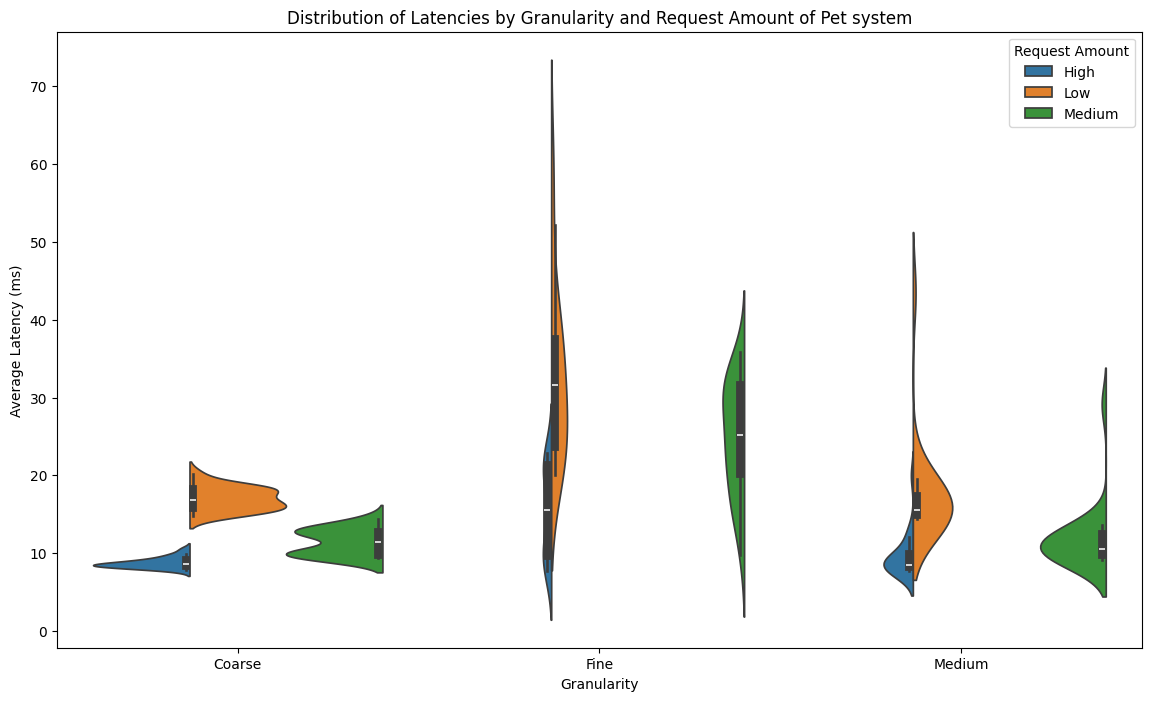

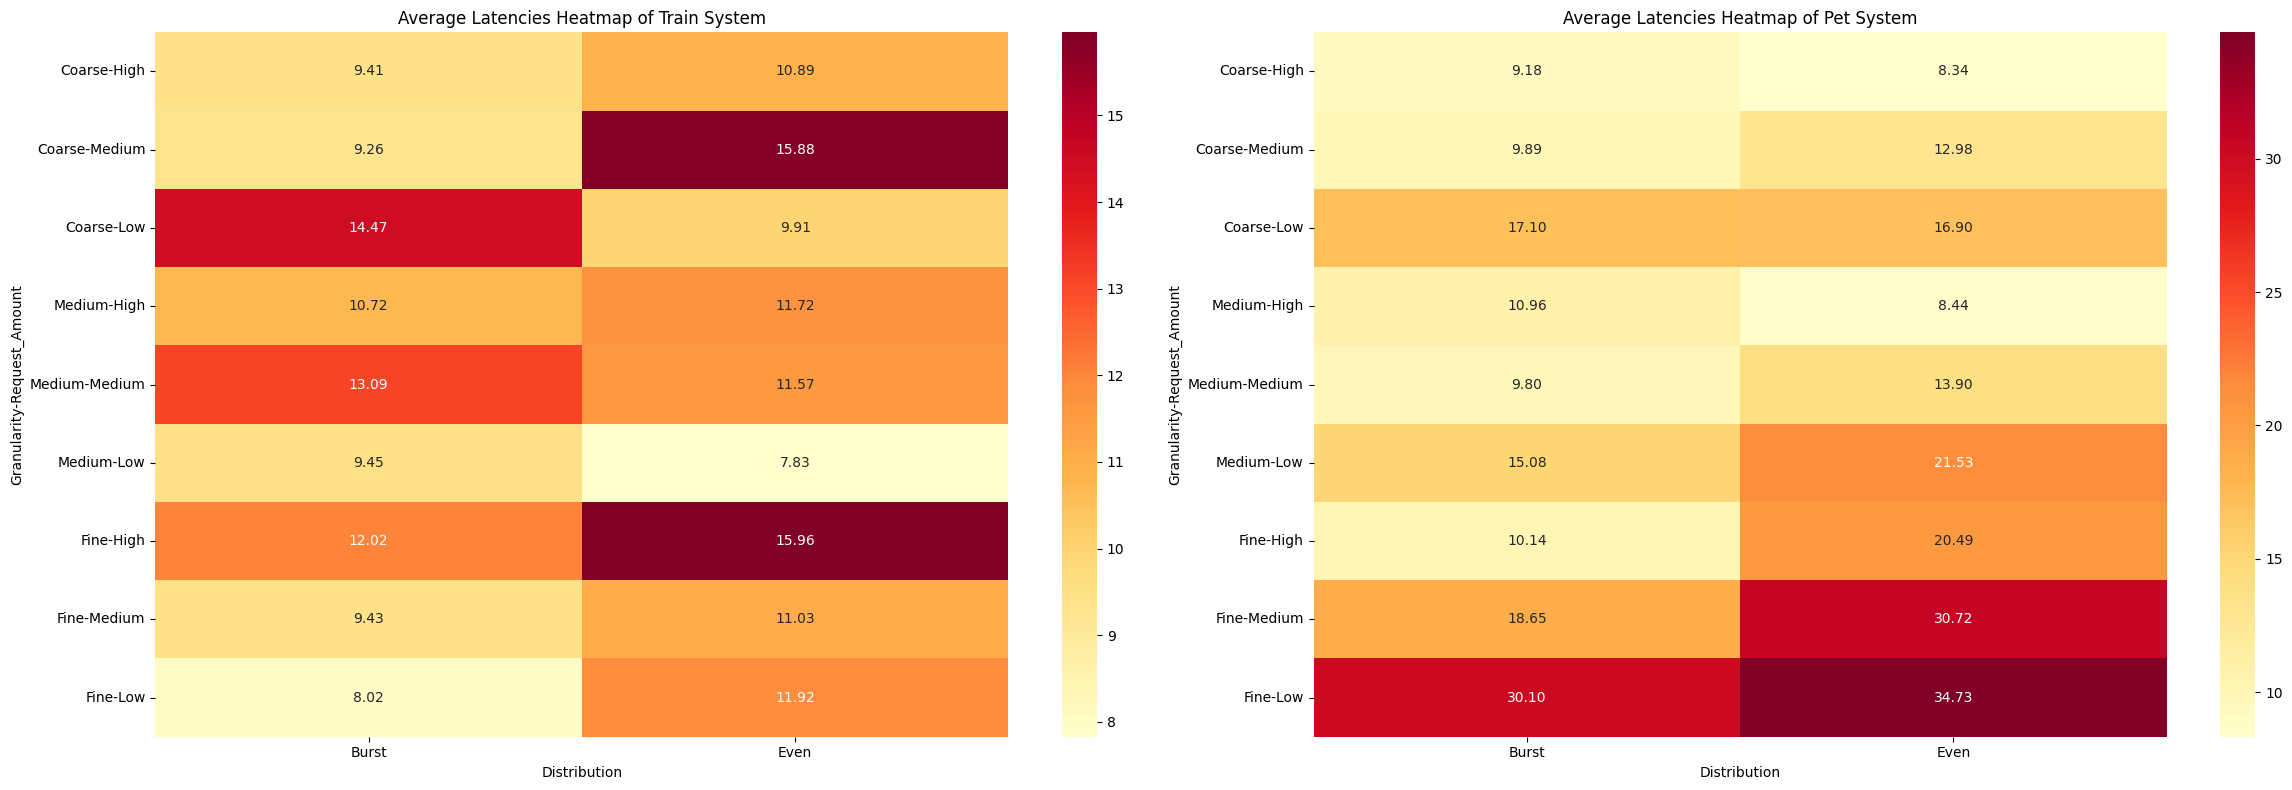

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')
df_pet = pd.read_csv('../processed_data/latency_summary_pet_clean_1.csv')
plt.style.use('default')
order = ['Fine', 'Medium', 'Coarse']
df_train['Granularity'] = df_train['Granularity'].replace({'fine': 'Fine', 'med': 'Medium', 'coarse': 'Coarse'})
df_pet['Granularity'] = df_pet['Granularity'].replace({'fine': 'Fine', 'med': 'Medium', 'coarse': 'Coarse'})
df_train['Request_Amount'] = df_train['Request_Amount'].replace({'high': 'High', 'med': 'Medium', 'low': 'Low'})
df_pet['Request_Amount'] = df_pet['Request_Amount'].replace({'high': 'High', 'med': 'Medium', 'low': 'Low'})
df_train['Distribution'] = df_train['Distribution'].replace({'even':"Even","burst":"Burst"})
df_pet['Distribution'] = df_pet['Distribution'].replace({'even':"Even","burst":"Burst" })
# boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Granularity', y='Average_Latency', data=df_train, order=order)
plt.ylabel('Average Latency (ms)')
plt.savefig('latency_by_granularity_boxplot_train.png')
plt.close()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Granularity', y='Average_Latency', data=df_pet, order=order)
plt.ylabel('Average Latency (ms)')
plt.savefig('latency_by_granularity_boxplot_pet.png')
plt.close()

# Violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Granularity', y='Average_Latency', hue='Request_Amount', data=df_train, split=True)
plt.title('Distribution of Latencies by Granularity and Request Amount of Train system')
plt.ylabel('Average Latency (ms)')
plt.legend(title='Request Amount')
plt.savefig('latency_by_granularity_and_request_violinplot_train.png')
plt.close()

plt.figure(figsize=(14, 8))
sns.violinplot(x='Granularity', y='Average_Latency', hue='Request_Amount', data=df_pet, split=True)
plt.title('Distribution of Latencies by Granularity and Request Amount of Pet system')
plt.ylabel('Average Latency (ms)')
plt.legend(title='Request Amount')
plt.savefig('latency_by_granularity_and_request_violinplot_pet.png')


granularity_order = ['Coarse', 'Medium', 'Fine']
request_amount_order = ['High', 'Medium', 'Low']
def reorder_pivot(df):
    pivot = df.pivot_table(values='Average_Latency',
                           index=['Granularity', 'Request_Amount'],
                           columns='Distribution',
                           aggfunc='mean')
    return pivot.reindex(index=pd.MultiIndex.from_product(
        [granularity_order, request_amount_order],
        names=['Granularity', 'Request_Amount']
    ))

pivot_df_train = reorder_pivot(df_train)
pivot_df_pet = reorder_pivot(df_pet)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
sns.heatmap(pivot_df_train, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1)
ax1.set_title('Average Latencies Heatmap of Train System')

sns.heatmap(pivot_df_pet, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Average Latencies Heatmap of Pet System')

plt.tight_layout()
plt.savefig('latency_heatmap_combined.png')
plt.savepdf('latency_heatmap_combined.pdf')
plt.close()


#Line plot
plt.figure(figsize=(14, 8))
for granularity in df_train['Granularity'].unique():
    data = df_train[df_train['Granularity'] == granularity]
    plt.plot(data['Iteration'], data['Average_Latency'], label=granularity, marker='o')
plt.title('Latencies Across Iterations by Granularity of Train System')
plt.xlabel('Iteration')
plt.ylabel('Average Latency (ms)')
plt.legend()
plt.savefig('latency_across_iterations_train.png')
plt.close()

plt.figure(figsize=(14, 8))
for granularity in df_pet['Granularity'].unique():
    data = df_pet[df_pet['Granularity'] == granularity]
    plt.plot(data['Iteration'], data['Average_Latency'], label=granularity, marker='o')
plt.title('Latencies Across Iterations by Granularity of Pet System')
plt.xlabel('Iteration')
plt.ylabel('Average Latency (ms)')
plt.legend()
plt.savefig('latency_across_iterations_pet.png')
plt.close()

print("Graphs have been saved as PNG files.")

In [4]:
import pandas as pd
from scipy.stats import f_oneway, levene, shapiro
df_train = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')
df_pet = pd.read_csv('../processed_data/latency_summary_pet_clean_1.csv')

def analyze_system(df, system_name):
    print(f"Analyzing {system_name} system")

    # Check normality
    _, p_coarse = shapiro(df[df['Granularity'] == 'coarse']['Average_Latency'])
    _, p_medium = shapiro(df[df['Granularity'] == 'med']['Average_Latency'])
    _, p_fine = shapiro(df[df['Granularity'] == 'fine']['Average_Latency'])

    print("Shapiro-Wilk test p-values:")
    print(f"Coarse: {p_coarse}, Medium: {p_medium}, Fine: {p_fine}")

# Analyze each system
analyze_system(df_train, "Train Ticket")
analyze_system(df_pet, "Pet Clinic")

Analyzing Train Ticket system
Shapiro-Wilk test p-values:
Coarse: 6.974047443224991e-09, Medium: 7.321686914180318e-09, Fine: 5.277192164911893e-08
Levene's test p-value: 0.5957923862887728

ANOVA results:
                     sum_sq     df         F    PR(>F)
C(Granularity)    26.968817    2.0  0.547125  0.579603
Residual        4288.391394  174.0       NaN       NaN

Tukey's HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
coarse   fine  -0.2076 0.9722 -2.3783  1.963  False
coarse    med  -0.9063 0.5779 -3.0489 1.2364  False
  fine    med  -0.6986 0.7275 -2.8693  1.472  False
---------------------------------------------------
Analyzing Pet Clinic system
Shapiro-Wilk test p-values:
Coarse: 6.38036075461192e-05, Medium: 2.1971337101366784e-09, Fine: 0.005879199028859601
Levene's test p-value: 8.719630674920403e-07

ANOVA results:
                     sum_sq     df   

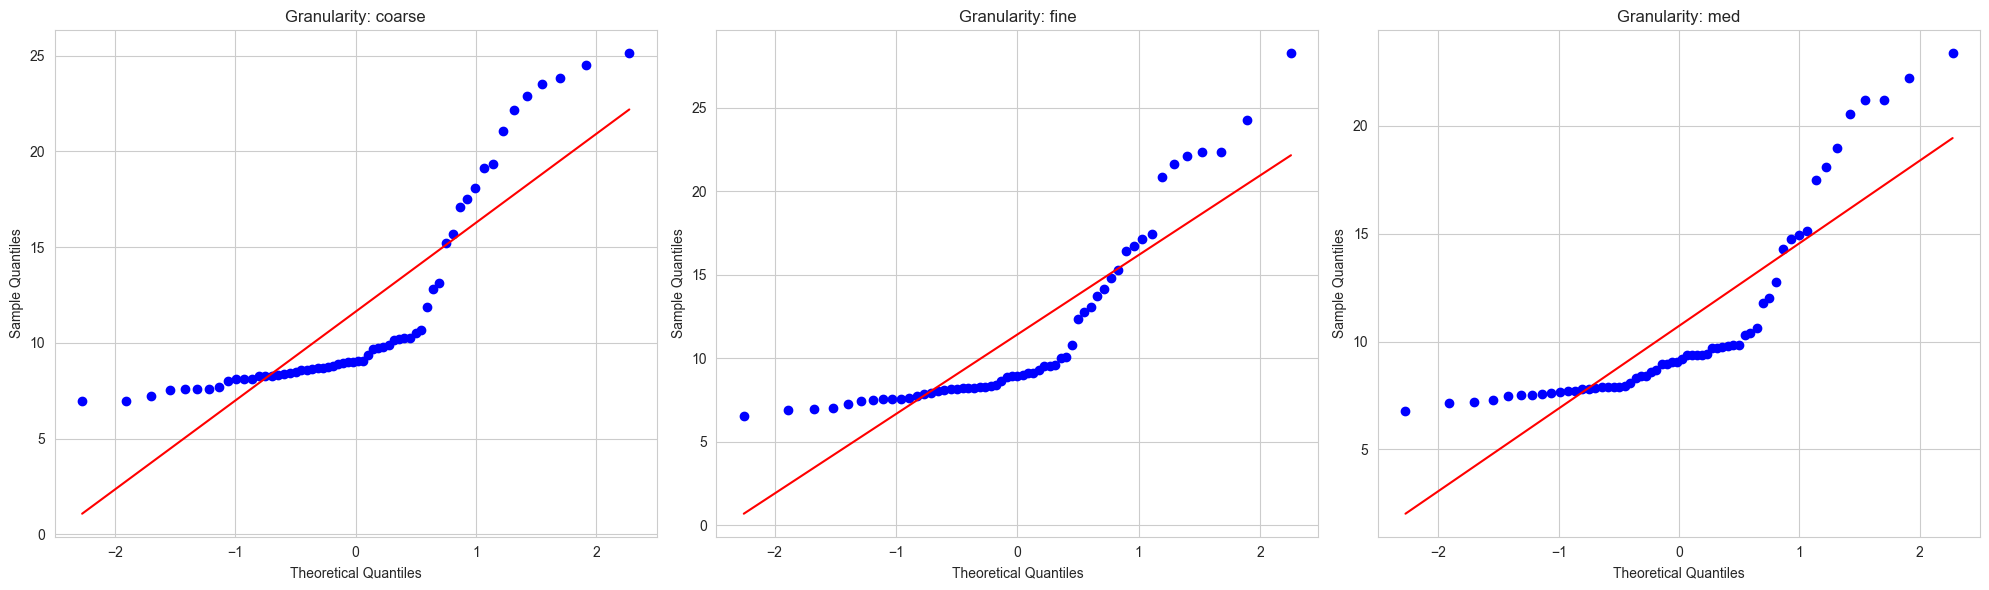

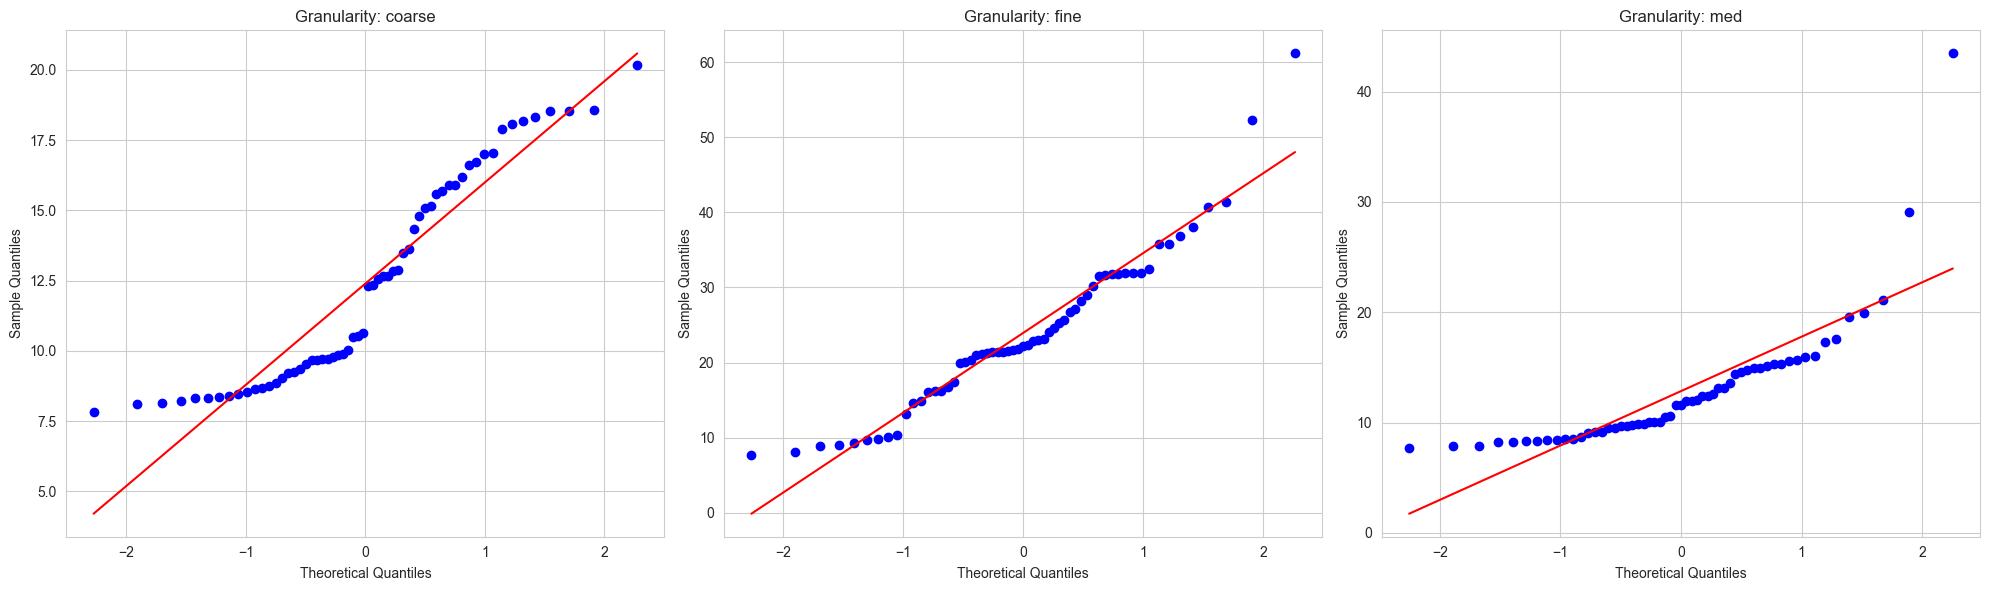

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def create_qq_plots(df, column, group_column):
    groups = df[group_column].unique()
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    #fig.suptitle(f"Q-Q Plots for {column} by {group_column}", fontsize=16)

    for i, group in enumerate(groups):
        data = df[df[group_column] == group][column]

        # Create Q-Q plot
        stats.probplot(data, dist="norm", plot=axs[i])

        # Customize subplot
        axs[i].set_title(f"{group_column}: {group}")
        axs[i].set_xlabel("Theoretical Quantiles")
        axs[i].set_ylabel("Sample Quantiles")

    plt.tight_layout()
    plt.show()

create_qq_plots(df_train, 'Average_Latency', 'Granularity')
create_qq_plots(df_pet, 'Average_Latency', 'Granularity')


In [18]:
import pandas as pd
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

def non_parametric_analysis(df, system_name):
    print(f"\nNon-parametric analysis for {system_name} system")

    # Kruskal-Wallis H-test
    groups = [group for _, group in df.groupby('Granularity')['Average_Latency']]
    h_statistic, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis test: H-statistic = {h_statistic:.4f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("Significant differences found. Performing post-hoc analysis.")

        # Dunn's test for post-hoc analysis
        dunn_results = posthoc_dunn(df, val_col='Average_Latency', group_col='Granularity', p_adjust='bonferroni')
        print("\nDunn's test results:")
        print(dunn_results)

        # Cliff's Delta for effect size
        granularities = df['Granularity'].unique()
        for i in range(len(granularities)):
            for j in range(i+1, len(granularities)):
                g1, g2 = granularities[i], granularities[j]
                d, _ = cliffs_delta(df[df['Granularity'] == g1]['Average_Latency'],
                                    df[df['Granularity'] == g2]['Average_Latency'])
                print(f"Cliff's Delta between {g1} and {g2}: {d:.4f}")
    else:
        print("No significant differences found across granularity levels.")

df_train = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')
df_pet = pd.read_csv('../processed_data/latency_summary_pet_clean_1.csv')

non_parametric_analysis(df_train, "Train Ticket")
non_parametric_analysis(df_pet, "Pet Clinic")


Non-parametric analysis for Train Ticket system
Kruskal-Wallis test: H-statistic = 1.3044, p-value = 0.5209
No significant differences found across granularity levels.

Non-parametric analysis for Pet Clinic system
Kruskal-Wallis test: H-statistic = 56.4112, p-value = 0.0000
Significant differences found. Performing post-hoc analysis.

Dunn's test results:
              coarse          fine           med
coarse  1.000000e+00  2.328932e-10  1.000000e+00
fine    2.328932e-10  1.000000e+00  2.506190e-10
med     1.000000e+00  2.506190e-10  1.000000e+00
Cliff's Delta between coarse and fine: -0.7085
Cliff's Delta between coarse and med: 0.0263
Cliff's Delta between fine and med: 0.6795


In [21]:
import pandas as pd
import numpy as np
df = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')

def create_binary_columns(df, column_name, prefix):
    unique_values = df[column_name].unique()
    for value in unique_values:
        new_column_name = f'is_{prefix}_{value}'.lower()
        df[new_column_name] = (df[column_name] == value).astype(int)
    return df

df = create_binary_columns(df, 'Granularity', 'gran')
df = create_binary_columns(df, 'Distribution', 'dist')
df = create_binary_columns(df, 'Request_Amount', 'req')

df.to_csv('train_dataset_with_binary_variables.csv', index=False)

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from statsmodels.stats.multitest import multipletests

def non_parametric_analysis(df, system_name):
    print(f"\nNon-parametric analysis for {system_name} system")

    granularities = df['Granularity'].unique()
    p_values = []
    comparisons = []
    alpha = 0.05

    for i in range(len(granularities)):
        for j in range(i+1, len(granularities)):
            g1, g2 = granularities[i], granularities[j]

            # Mann-Whitney U-test
            statistic, p_value = mannwhitneyu(
                df[df['Granularity'] == g1]['Average_Latency'],
                df[df['Granularity'] == g2]['Average_Latency']
            )

            p_values.append(p_value)
            comparisons.append((g1, g2))

            print(f"Mann-Whitney U-test between {g1} and {g2}: U-statistic = {statistic:.4f}, p-value = {p_value:.4f}")

    # Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=alpha, method='holm')

    # Calculate adjusted alpha levels
    n = len(p_values)
    sorted_indices = np.argsort(p_values)
    adjusted_alphas = [alpha / (n - i) for i in range(n)]

    print("\nHolm-Bonferroni results:")
    for i, ((g1, g2), p, p_adj, rej) in enumerate(zip(comparisons, p_values, p_corrected, reject)):
        adj_alpha = adjusted_alphas[sorted_indices[i]]
        print(f"{g1} vs {g2}: original p-value = {p:.4f}, adjusted p-value = {p_adj}, adjusted alpha = {adj_alpha:.4f}, rejected: {rej}")

    # Cliff's Delta for effect size
    print("\nCliff's Delta effect sizes:")
    for g1, g2 in comparisons:
        d, _ = cliffs_delta(
            df[df['Granularity'] == g1]['Average_Latency'],
            df[df['Granularity'] == g2]['Average_Latency']
        )
        print(f"Cliff's Delta between {g1} and {g2}: {d:.4f}")

df_train = pd.read_csv('../processed_data/latency_summary_train_clean_1.csv')
df_pet = pd.read_csv('../processed_data/latency_summary_pet_clean_1.csv')

non_parametric_analysis(df_train, "Train Ticket")
non_parametric_analysis(df_pet, "Pet Clinic")


Non-parametric analysis for Train Ticket system
Mann-Whitney U-test between coarse and fine: U-statistic = 1880.0000, p-value = 0.3553
Mann-Whitney U-test between coarse and med: U-statistic = 1995.0000, p-value = 0.3073
Mann-Whitney U-test between fine and med: U-statistic = 1746.0000, p-value = 0.8465

Holm-Bonferroni results:
coarse vs fine: original p-value = 0.3553, adjusted p-value = 0.9219619644863704, adjusted alpha = 0.0250, rejected: False
coarse vs med: original p-value = 0.3073, adjusted p-value = 0.9219619644863704, adjusted alpha = 0.0167, rejected: False
fine vs med: original p-value = 0.8465, adjusted p-value = 0.9219619644863704, adjusted alpha = 0.0500, rejected: False

Cliff's Delta effect sizes:
Cliff's Delta between coarse and fine: 0.0994
Cliff's Delta between coarse and med: 0.1083
Cliff's Delta between fine and med: 0.0211

Non-parametric analysis for Pet Clinic system
Mann-Whitney U-test between coarse and fine: U-statistic = 516.0000, p-value = 0.0000
Mann-Wh